<a href="https://colab.research.google.com/github/Mayan-Ryan/QML/blob/main/QML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Quantum machine learning

In [14]:
!pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 27.5 MB/s 
     |████████████████████████████████| 1.6 MB 45.9 MB/s 
     |████████████████████████████████| 13.7 MB 48.0 MB/s 
     |████████████████████████████████| 108 kB 61.5 MB/s 


In [15]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

In [16]:
n_epochs = 30   
n_layers = 1    
PREPROCESS = True  
n_train = 30  
n_test = 10   
x_train = X_train[:n_train]
x_test = X_test[:n_test]
y_train = y_train[:n_train]
y_test = y_test[:n_test]

In [17]:
dev = qml.device("default.qubit", wires=4)
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)
        
    RandomLayers(rand_params, wires=list(range(4)))

    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [18]:
def quanv(image):

    out = np.zeros((14, 14, 4))

    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
  
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [20]:
if PREPROCESS == True:  
    q_x_train = []
    for idx, img in enumerate(x_train):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_x_train.append(quanv(img))
    q_x_train = np.asarray(q_x_train)

In [21]:
if PREPROCESS == True:
    q_x_test = []
    for idx, img in enumerate(x_test):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_x_test.append(quanv(img))
    q_x_test = np.asarray(q_x_test)

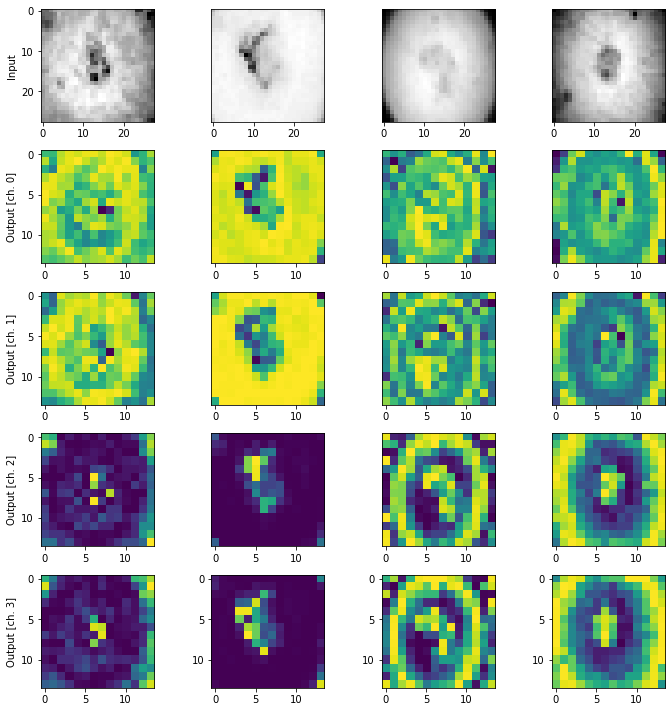

In [23]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(x_train[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_x_train[k, :, :, c])

plt.tight_layout()
plt.show()

In [24]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [27]:
q_model = MyModel()

q_history = q_model.fit(
    q_x_train,
    y_train,
    validation_data=(q_x_test, y_test),
    batch_size=4,
    epochs=n_epochs,
    verbose=2
)

Epoch 1/30
8/8 - 1s - loss: 2.5555 - accuracy: 0.2667 - val_loss: 2.4524 - val_accuracy: 0.2000 - 1s/epoch - 126ms/step
Epoch 2/30
8/8 - 0s - loss: 1.7250 - accuracy: 0.3333 - val_loss: 2.5364 - val_accuracy: 0.2000 - 34ms/epoch - 4ms/step
Epoch 3/30
8/8 - 0s - loss: 1.3461 - accuracy: 0.5333 - val_loss: 2.5844 - val_accuracy: 0.2000 - 29ms/epoch - 4ms/step
Epoch 4/30
8/8 - 0s - loss: 1.1248 - accuracy: 0.7333 - val_loss: 2.5540 - val_accuracy: 0.2000 - 27ms/epoch - 3ms/step
Epoch 5/30
8/8 - 0s - loss: 0.9255 - accuracy: 0.8667 - val_loss: 2.5549 - val_accuracy: 0.0000e+00 - 27ms/epoch - 3ms/step
Epoch 6/30
8/8 - 0s - loss: 0.7893 - accuracy: 0.9000 - val_loss: 2.6034 - val_accuracy: 0.0000e+00 - 26ms/epoch - 3ms/step
Epoch 7/30
8/8 - 0s - loss: 0.6801 - accuracy: 0.9333 - val_loss: 2.6236 - val_accuracy: 0.1000 - 34ms/epoch - 4ms/step
Epoch 8/30
8/8 - 0s - loss: 0.5907 - accuracy: 0.9333 - val_loss: 2.6035 - val_accuracy: 0.0000e+00 - 30ms/epoch - 4ms/step
Epoch 9/30
8/8 - 0s - loss: 

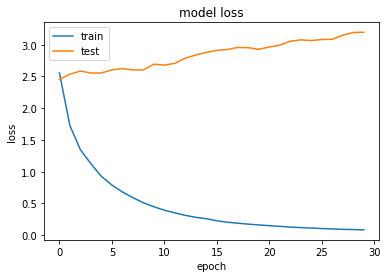

In [28]:
# summarize history for loss
plt.plot(q_history.history['loss'])
plt.plot(q_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

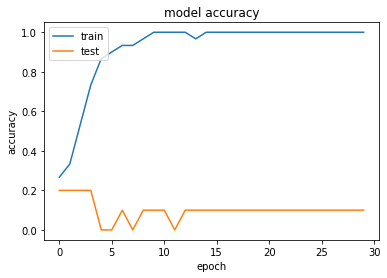

In [29]:
# summarize history for accuracy
plt.plot(q_history.history['accuracy'])
plt.plot(q_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
score = q_model.evaluate(q_x_test, y_test)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

1/1 [==============================] - 0s 20ms/step - loss: 3.1967 - accuracy: 0.1000
Test Loss: 3.196678400039673
Test accuracy: 0.10000000149011612
